In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read Train and Test data
train_df = pd.read_csv("/content/drive/MyDrive/ML_DL/KaggleCompetions/DisasterTweets/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/ML_DL/KaggleCompetions/DisasterTweets/test.csv")

In [3]:
# Non disaster data sample
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [4]:
# Disaster data sample
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

Disasters count: 3271
Non Disasters count: 4342
Imbalance Ratio: 0.7533394748963611



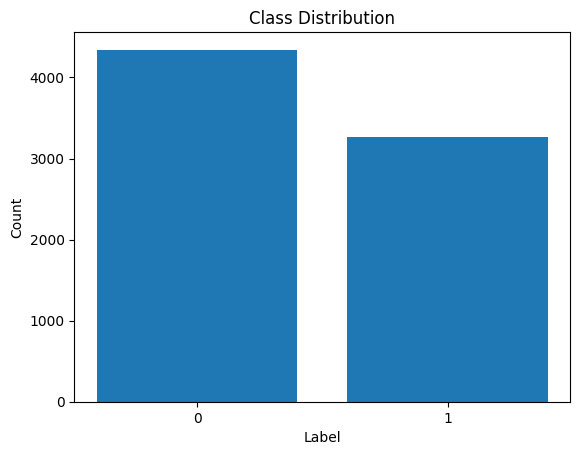

In [5]:
# Check if the data is balanced


def class_distribution(df):
  # Count the number of occurrences of each label
  label_counts = df["target"].value_counts()

  # Calculate the class imbalance ratio
  imbalance_ratio = label_counts[1] / label_counts[0]

  print(f"Disasters count: {label_counts[1]}")
  print(f"Non Disasters count: {label_counts[0]}")
  print(f"Imbalance Ratio: {imbalance_ratio}\n")


  # Create a bar plot to visualize the class distribution
  plt.bar(label_counts.index, label_counts.values)
  plt.xlabel("Label")
  plt.ylabel("Count")
  plt.title("Class Distribution")
  plt.xticks(label_counts.index, ['0', '1'])
  plt.show()

class_distribution(train_df)


In [6]:
# Preprocess the tweets
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply stemming using PorterStemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)

# Preprocess train data
train_df['text'] = train_df['text'].apply(preprocess_text)

# Preprocess test data
test_df['text'] = test_df['text'].apply(preprocess_text)



In [7]:
# Data Sample after preprocessing
train_df[train_df["target"] == 0]["text"].values[1]

'love fruit'

In [8]:
# Method that get X_train and X_test and trasform them into BoW vectors
def bow_features(X_train, X_test):

  count_vectorizer = feature_extraction.text.CountVectorizer()
  train_vectors = count_vectorizer.fit_transform(X_train)
  test_vectors = count_vectorizer.transform(X_test)

  return train_vectors, test_vectors

#train_vectors , test_vectors = bow_features(train_df["text"], test_df["text"])


In [9]:
# Method that get X_train and X_test and trasform them into TFIDF vectors
def tfidf_features(X_train, X_test):

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test =  tfidf_vectorizer.transform(X_test)

    return X_train, X_test, tfidf_vectorizer.vocabulary_
train_vectors , test_vectors, _ = tfidf_features(train_df["text"], test_df["text"])


In [10]:
# Grid search to find the best models and params
def grid_search_models(X, y):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Ridge Regression': RidgeClassifier(),
        'MultinomialNB': MultinomialNB(),
        }
    
    param_grid = {
        'Logistic Regression': {},
        'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
        'MultinomialNB': {'alpha': [0.1, 1, 10]},
        }
    
    best_model = None
    best_score = -float('inf')
    
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grid[model_name], scoring='f1', cv=5)
        grid_search.fit(X, y)
        
        if grid_search.best_score_ > best_score:
            best_model = grid_search.best_estimator_
            best_score = grid_search.best_score_
        
    
   
    
    return best_model, best_score

model, best_score = grid_search_models(train_vectors, train_df["target"])


print(f'best_model: {model}')
print(f'best score: {best_score}')    


best_model: MultinomialNB(alpha=0.1)
best score: 0.6659496716421716


In [11]:
# Train the model on our data
model.fit(train_vectors, train_df["target"])

MultinomialNB(alpha=0.1)

In [12]:
# Read the sample_submission file
sample_submission = pd.read_csv("/content/drive/MyDrive/ML_DL/KaggleCompetions/DisasterTweets/sample_submission.csv")

In [13]:
# Preidict the test data
sample_submission["target"] = model.predict(test_vectors)

In [14]:
# Save the predictions in submission.csv file
sample_submission.to_csv("/content/drive/MyDrive/ML_DL/KaggleCompetions/DisasterTweets/submission.csv", index=False)